In [53]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.filters import gabor_kernel
import matplotlib.pyplot as plt
import my_functions as ext
import random
import tqdm


In [54]:
# Prepare gabor filter bank
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

# TRAINING IMAGES

In [126]:
# load segmented images
# segmented image directory
segmented_image_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/train"

segmented_image_files = [file for file in os.listdir(segmented_image_directory) if file != '.DS_Store']

In [127]:
# Load segmented images
segmented_images = []
for segmented_image_file in segmented_image_files:
    if segmented_image_file.startswith('.'):
        continue  # Skip files starting with '.' (Mac adds a .DS_Store file)

    segmented_image_path = os.path.join(segmented_image_directory, segmented_image_file)
    segmented_image = cv2.imread(segmented_image_path)
    if segmented_image is None:
        print(f"Error loading image: {segmented_image_file}")
        continue

    # Convert color channel ordering from BGR to RGB
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # Convert image to integer data type
    segmented_image_int = segmented_image_rgb.astype(np.uint8)

    segmented_images.append(segmented_image_int)

Error loading image: trainclasses_train.csv


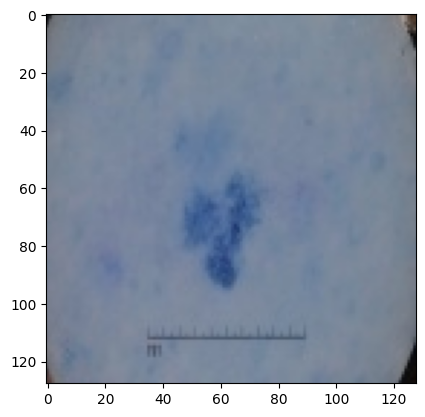

In [128]:
# sanity check
image_x = random.randint(0, len(segmented_images))
plt.imshow(segmented_images[image_x])
plt.show()

In [129]:
# Extract features
# Create an empty DataFrame
df_features_train = pd.DataFrame(
    columns=['image_id'])

lbp_features = []
hog_features = []
edge_features = []
gabor_features = []
mean_features = []
min_features = []
std_features = []
skewness_features = []
kurtosis_features = []

In [130]:
# Create an iterator with a progress bar
iterator = tqdm.tqdm(enumerate(segmented_images), total=len(segmented_images), desc="Extracting features from training images")

skipped_images = 0
# Iterate over segmented images and extract features
for i, segmented_image in iterator:
    # Check if the segmented image is blank (all black pixels), if it is, skip to next image
    if np.all(segmented_image == 0):
        skipped_images += 1
        continue

    # Extract features for the current image
    lbp_features.append(ext.extract_lbp_features(segmented_image))
    edge_features.append(ext.findehd(segmented_image))
    hog_features.append(ext.extract_hog_features(segmented_image))
    gabor_features.append(ext.extract_gabor_features(segmented_image, kernels))
    mean_feature, min_feature, std_feature, skewness_feature, kurtosis_feature = ext.extract_color_features(
        segmented_image)
    mean_features.append(mean_feature)
    min_features.append(min_feature)
    std_features.append(std_feature)
    skewness_features.append(skewness_feature)
    kurtosis_features.append(kurtosis_feature)

    # Get the corresponding image ID (file name)
    image_id = os.path.splitext(segmented_image_files[i])[0]

    # Create a row for the DataFrame with the features and image ID
    row = pd.DataFrame({
        'image_id': [image_id]
    })

    # Append the row DataFrame to the main DataFrame
    df_features_train = pd.concat([df_features_train, row], ignore_index=True)

Extracting features from training images: 100%|██████████| 2000/2000 [14:35<00:00,  2.29it/s]


In [131]:
print(f"Number of skipped blank images from training data: {skipped_images}")

Number of skipped blank images from training data: 0


In [132]:
df_lbp_features = pd.DataFrame(np.array(lbp_features))
column_labels = [f"lpb_{i + 1}" for i in range(df_lbp_features.shape[1])]
df_lbp_features.columns = column_labels

df_edge_features = pd.DataFrame(np.array(edge_features))
column_labels = [f"edge_{i + 1}" for i in range(df_edge_features.shape[1])]
df_edge_features.columns = column_labels

df_hog_features = pd.DataFrame(np.array(hog_features))
column_labels = [f"hog_{i + 1}" for i in range(df_hog_features.shape[1])]
df_hog_features.columns = column_labels

for i, kernel in enumerate(kernels):
    column_labels = [f'k{i + 1}_mean', f'k{i + 1}_var']
    feats = np.array(gabor_features)[:, i, :]
    df_gabor_features = pd.DataFrame(feats, columns=column_labels)
    df_features_training = pd.concat([df_features_train, df_gabor_features], axis=1)

df_mean_features = pd.DataFrame(np.array(mean_features))
column_labels = ['r_mean', 'g_mean', 'b_mean', 'l_mean', 'u_mean', 'v_mean']
df_mean_features.columns = column_labels

df_min_features = pd.DataFrame(np.array(min_features))
column_labels = ['r_min', 'g_min', 'b_min', 'l_min', 'u_min', 'v_min']
df_min_features.columns = column_labels

df_std_features = pd.DataFrame(np.array(std_features))
column_labels = ['r_std', 'g_std', 'b_std', 'l_std', 'u_std', 'v_std']
df_std_features.columns = column_labels

df_skewness_features = pd.DataFrame(np.array(skewness_features))
column_labels = ['r_skew', 'g_skew', 'b_skew', 'l_skew', 'u_skew', 'v_skew']
df_skewness_features.columns = column_labels

df_kurtosis_features = pd.DataFrame(np.array(kurtosis_features))
column_labels = ['r_kurt', 'g_kurt', 'b_kurt', 'l_kurt', 'u_kurt', 'v_kurt']
df_kurtosis_features.columns = column_labels

df_features_train = pd.concat(
    [df_features_train, df_lbp_features, df_hog_features, df_edge_features, df_mean_features, df_min_features,
     df_std_features, df_skewness_features, df_kurtosis_features], axis=1)


In [138]:
df_features_train

,image_id,lpb_1,lpb_2,lpb_3,lpb_4,lpb_5,lpb_6,lpb_7,lpb_8,lpb_9,...,l_skew,u_skew,v_skew,r_kurt,g_kurt,b_kurt,l_kurt,u_kurt,v_kurt,class
0,ISIC_0,0.094055,0.055176,0.028809,0.010071,0.006836,0.005981,0.003174,0.003296,0.001648,...,-0.461166,-0.106840,-0.180933,-1.652461,-1.545128,-1.178488,-1.508182,-1.725032,-1.760378,2
1,ISIC_1,0.078186,0.039978,0.032654,0.015076,0.018372,0.010742,0.007874,0.009338,0.008362,...,-3.268622,-1.147000,-2.743851,8.126298,9.467787,12.263207,9.986512,2.260995,7.665037,2
2,ISIC_10,0.081482,0.045288,0.033447,0.014282,0.010559,0.006470,0.004822,0.004761,0.005310,...,-1.371514,-1.180500,-1.610327,-0.216280,0.614615,2.201554,0.875879,0.365264,1.287582,2
3,ISIC_100,0.087708,0.048096,0.038940,0.017212,0.012085,0.009277,0.005310,0.005432,0.004028,...,-3.189521,0.000187,-1.557097,5.219501,11.138290,26.673607,13.900293,-0.934448,2.822949,2
4,ISIC_1000,0.089966,0.042480,0.036438,0.016724,0.015137,0.008545,0.006165,0.007141,0.004395,...,-0.459341,0.663366,-2.087619,-0.499640,-0.117450,-0.209421,-0.101436,0.634136,6.263496,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ISIC_995,0.091919,0.045227,0.029419,0.017761,0.013184,0.008667,0.006287,0.006287,0.005310,...,-2.527616,-1.146041,-2.607720,4.679602,6.936369,7.402657,7.354309,2.184312,6.133805,2
1996,ISIC_996,0.092041,0.044312,0.032715,0.013611,0.008911,0.005981,0.004272,0.004333,0.003235,...,-3.580109,-0.881935,-2.813588,21.844648,20.677071,5.922600,22.802143,1.774915,11.649295,2
1997,ISIC_997,0.090332,0.040527,0.033691,0.016418,0.014893,0.008057,0.006165,0.005798,0.005127,...,-2.259351,-1.474697,-2.421451,5.948369,5.485467,0.755200,5.782666,3.363216,5.085608,2
1998,ISIC_998,0.097229,0.050232,0.031311,0.013672,0.011719,0.007202,0.004333,0.004578,0.004639,...,-2.607013,-1.516459,-1.571090,4.002080,9.654463,39.927366,13.177494,1.359902,1.791244,2


In [135]:
# Load the class CSV file with classes
# Define the folder path where the class CSV file is located
class_folder_train = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/train"

# Load the class CSV file
class_csv_file = [file for file in os.listdir(class_folder_train) if file.endswith(".csv")]

class_csv_path = os.path.join(class_folder_train, class_csv_file[0])
df_classes_train = pd.read_csv(class_csv_path, usecols=["image_id", "class"])


In [136]:
df_classes_train

,image_id,class
0,ISIC_0,2
1,ISIC_1,2
2,ISIC_2,0
3,ISIC_3,2
4,ISIC_4,0
...,...,...
1995,ISIC_1995,1
1996,ISIC_1996,1
1997,ISIC_1997,1
1998,ISIC_1998,0


In [137]:
# Merge df_features with df_classes based on image_id
df_features_train = pd.merge(df_features_train, df_classes_train, on="image_id", how="inner")

In [139]:
# Drop rows with missing or null class information
df_features_train = df_features_train.dropna(subset=["class"])

In [140]:
# Export DataFrame as csv file
# Define the file path and name
save_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/SVM"
csv_file_path = os.path.join(save_directory, "features_train.csv")

# TEST IMAGES

In [111]:
# load testing segmented images
# segmented image directory
segmented_image_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/test"

segmented_image_files = [file for file in os.listdir(segmented_image_directory) if file != '.DS_Store']

In [112]:
# Load segmented images
segmented_images = []
for segmented_image_file in segmented_image_files:
    if segmented_image_file.startswith('.'):
        continue  # Skip files starting with '.' (Mac adds a .DS_Store file)

    # Check if the file has the ".jpg" extension
    if not segmented_image_file.lower().endswith('.jpg'):
        continue

    segmented_image_path = os.path.join(segmented_image_directory, segmented_image_file)
    segmented_image = cv2.imread(segmented_image_path)
    if segmented_image is None:
        print(f"Error loading image: {segmented_image_file}")
        continue

    # Convert color channel ordering from BGR to RGB
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # Convert image to integer data type
    segmented_image_int = segmented_image_rgb.astype(np.uint8)

    segmented_images.append(segmented_image_int)


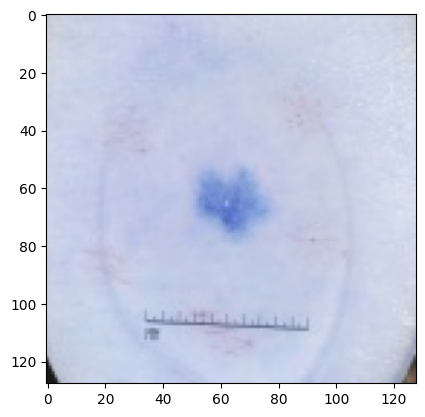

In [113]:
# sanity check
image_x = random.randint(0, len(segmented_images))
plt.imshow(segmented_images[image_x])
plt.show()

In [114]:
# Extract features
# Create an empty DataFrame
df_features_test = pd.DataFrame(
    columns=['image_id'])

lbp_features = []
hog_features = []
edge_features = []
gabor_features = []
mean_features = []
min_features = []
std_features = []
skewness_features = []
kurtosis_features = []

In [115]:
# Create an iterator with a progress bar
iterator = tqdm.tqdm(enumerate(segmented_images), total=len(segmented_images), desc="Extracting features from testing data")

skipped_images = 0
# Iterate over segmented images and extract features
for i, segmented_image in iterator:
    # Check if the segmented image is blank (all black pixels)
    if np.all(segmented_image == 0):
        skipped_images += 1
        continue

    # Extract features for the current image
    lbp_features.append(ext.extract_lbp_features(segmented_image))
    edge_features.append(ext.findehd(segmented_image))
    hog_features.append(ext.extract_hog_features(segmented_image))
    gabor_features.append(ext.extract_gabor_features(segmented_image, kernels))
    mean_feature, min_feature, std_feature, skewness_feature, kurtosis_feature = ext.extract_color_features(
        segmented_image)
    mean_features.append(mean_feature)
    min_features.append(min_feature)
    std_features.append(std_feature)
    skewness_features.append(skewness_feature)
    kurtosis_features.append(kurtosis_feature)

    # Get the corresponding image ID (file name)
    image_id = os.path.splitext(segmented_image_files[i])[0]

    # Create a row for the DataFrame with the features and image ID
    row = pd.DataFrame({
        'image_id': [image_id]
    })

    # Append the row DataFrame to the main DataFrame
    df_features_test = pd.concat([df_features_test, row], ignore_index=True)

Extracting features from testing data: 100%|██████████| 600/600 [04:23<00:00,  2.28it/s]


In [116]:
print(f"Number of skipped blank images from testing data: {skipped_images}")

Number of skipped blank images from testing data: 0


In [117]:
df_lbp_features = pd.DataFrame(np.array(lbp_features))
column_labels = [f"lpb_{i + 1}" for i in range(df_lbp_features.shape[1])]
df_lbp_features.columns = column_labels

df_edge_features = pd.DataFrame(np.array(edge_features))
column_labels = [f"edge_{i + 1}" for i in range(df_edge_features.shape[1])]
df_edge_features.columns = column_labels

df_hog_features = pd.DataFrame(np.array(hog_features))
column_labels = [f"hog_{i + 1}" for i in range(df_hog_features.shape[1])]
df_hog_features.columns = column_labels

for i, kernel in enumerate(kernels):
    column_labels = [f'k{i + 1}_mean', f'k{i + 1}_var']
    feats = np.array(gabor_features)[:, i, :]
    df_gabor_features = pd.DataFrame(feats, columns=column_labels)
    df_features_test = pd.concat([df_features_test, df_gabor_features], axis=1)

df_mean_features = pd.DataFrame(np.array(mean_features))
column_labels = ['r_mean', 'g_mean', 'b_mean', 'l_mean', 'u_mean', 'v_mean']
df_mean_features.columns = column_labels

df_min_features = pd.DataFrame(np.array(min_features))
column_labels = ['r_min', 'g_min', 'b_min', 'l_min', 'u_min', 'v_min']
df_min_features.columns = column_labels

df_std_features = pd.DataFrame(np.array(std_features))
column_labels = ['r_std', 'g_std', 'b_std', 'l_std', 'u_std', 'v_std']
df_std_features.columns = column_labels

df_skewness_features = pd.DataFrame(np.array(skewness_features))
column_labels = ['r_skew', 'g_skew', 'b_skew', 'l_skew', 'u_skew', 'v_skew']
df_skewness_features.columns = column_labels

df_kurtosis_features = pd.DataFrame(np.array(kurtosis_features))
column_labels = ['r_kurt', 'g_kurt', 'b_kurt', 'l_kurt', 'u_kurt', 'v_kurt']
df_kurtosis_features.columns = column_labels

df_features_test = pd.concat(
    [df_features_test, df_lbp_features, df_hog_features, df_edge_features, df_mean_features, df_min_features,
     df_std_features, df_skewness_features, df_kurtosis_features], axis=1)


In [118]:
df_features_test

,image_id,k1_mean,k1_var,k2_mean,k2_var,k3_mean,k3_var,k4_mean,k4_var,k5_mean,...,b_skew,l_skew,u_skew,v_skew,r_kurt,g_kurt,b_kurt,l_kurt,u_kurt,v_kurt
0,ISIC_0,105.943298,799.777119,32.040039,91.567489,71.302429,319.235868,20.289673,4675.996290,105.943665,...,-2.297919,-1.999957,0.872857,1.549186,2.341915,2.622439,3.823980,3.169661,0.860100,1.670759
1,ISIC_1,108.225952,422.872652,33.115662,114.500844,72.844055,171.594273,8.926453,2169.786522,108.224365,...,-3.119049,-2.647047,3.317815,0.117981,4.766281,5.757262,11.488779,6.434503,23.401146,3.809857
2,ISIC_10,128.655945,248.182346,38.984009,33.405140,86.628174,91.576711,22.420715,5157.235901,128.658997,...,0.137280,0.993180,0.936246,1.158064,4.370507,2.947787,1.029829,2.919603,1.718018,2.095710
3,ISIC_100,113.305176,493.174568,34.290222,53.260437,76.271423,195.848265,11.963196,2881.050953,113.304077,...,-1.456108,-1.321453,1.418836,-0.733713,4.443476,0.173928,0.764914,0.376569,0.571795,2.098487
4,ISIC_101,121.435669,101.308972,36.954773,42.523406,81.758362,35.537375,2.426880,607.201074,121.437073,...,-5.979374,-6.946241,1.826879,0.628004,46.293899,51.820052,46.847200,56.342707,9.533926,1.434173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,ISIC_95,133.342224,92.264169,40.419800,11.805946,89.785156,33.332260,4.861206,1203.493309,133.342590,...,-6.097373,-3.715103,0.190689,-1.120689,12.002503,17.384856,63.440058,21.113807,3.444106,6.733917
596,ISIC_96,164.280090,214.562602,49.874207,21.910262,110.649170,87.869838,1.134338,284.358113,164.280701,...,-1.316479,-0.749525,-0.083579,-0.302546,-0.394009,-0.230693,2.635191,-0.134726,-0.511937,-1.290591
597,ISIC_97,100.750000,258.550903,30.454468,29.425661,67.802490,104.324271,13.413818,3209.611591,100.749207,...,-1.641173,-0.919442,0.415380,1.299310,2.008140,1.382725,2.970796,2.147222,0.312963,1.852250
598,ISIC_98,130.479126,244.290092,39.541565,42.308331,87.853577,80.969710,42.945374,8975.466437,130.477539,...,-1.422714,-1.312602,0.091346,-1.422780,0.743920,1.294157,1.910549,1.536347,4.895243,3.932565


In [120]:
# Load the class CSV file with classes
# Define the folder path where the class CSV file is located
class_folder_test = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/test"

# Load the class CSV file
class_csv_file = [file for file in os.listdir(class_folder_test) if file.endswith(".csv")]

class_csv_path = os.path.join(class_folder_test, class_csv_file[0])
df_classes_test = pd.read_csv(class_csv_path, usecols=["image_id", "class"])

In [121]:
df_classes_test

,image_id,class
0,ISIC_0,1
1,ISIC_1,2
2,ISIC_2,2
3,ISIC_3,1
4,ISIC_4,1
...,...,...
595,ISIC_595,2
596,ISIC_596,2
597,ISIC_597,2
598,ISIC_598,2


In [122]:
# Merge df_features with df_classes based on image_id
df_features_test = pd.merge(df_features_test, df_classes_test, on="image_id", how="inner")

In [123]:
# Drop rows with missing or null class information
df_features_test = df_features_test.dropna(subset=["class"])


In [124]:
df_features_test

,image_id,k1_mean,k1_var,k2_mean,k2_var,k3_mean,k3_var,k4_mean,k4_var,k5_mean,...,l_skew,u_skew,v_skew,r_kurt,g_kurt,b_kurt,l_kurt,u_kurt,v_kurt,class
0,ISIC_0,105.943298,799.777119,32.040039,91.567489,71.302429,319.235868,20.289673,4675.996290,105.943665,...,-1.999957,0.872857,1.549186,2.341915,2.622439,3.823980,3.169661,0.860100,1.670759,1
1,ISIC_1,108.225952,422.872652,33.115662,114.500844,72.844055,171.594273,8.926453,2169.786522,108.224365,...,-2.647047,3.317815,0.117981,4.766281,5.757262,11.488779,6.434503,23.401146,3.809857,2
2,ISIC_10,128.655945,248.182346,38.984009,33.405140,86.628174,91.576711,22.420715,5157.235901,128.658997,...,0.993180,0.936246,1.158064,4.370507,2.947787,1.029829,2.919603,1.718018,2.095710,1
3,ISIC_100,113.305176,493.174568,34.290222,53.260437,76.271423,195.848265,11.963196,2881.050953,113.304077,...,-1.321453,1.418836,-0.733713,4.443476,0.173928,0.764914,0.376569,0.571795,2.098487,0
4,ISIC_101,121.435669,101.308972,36.954773,42.523406,81.758362,35.537375,2.426880,607.201074,121.437073,...,-6.946241,1.826879,0.628004,46.293899,51.820052,46.847200,56.342707,9.533926,1.434173,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,ISIC_95,133.342224,92.264169,40.419800,11.805946,89.785156,33.332260,4.861206,1203.493309,133.342590,...,-3.715103,0.190689,-1.120689,12.002503,17.384856,63.440058,21.113807,3.444106,6.733917,2
596,ISIC_96,164.280090,214.562602,49.874207,21.910262,110.649170,87.869838,1.134338,284.358113,164.280701,...,-0.749525,-0.083579,-0.302546,-0.394009,-0.230693,2.635191,-0.134726,-0.511937,-1.290591,0
597,ISIC_97,100.750000,258.550903,30.454468,29.425661,67.802490,104.324271,13.413818,3209.611591,100.749207,...,-0.919442,0.415380,1.299310,2.008140,1.382725,2.970796,2.147222,0.312963,1.852250,1
598,ISIC_98,130.479126,244.290092,39.541565,42.308331,87.853577,80.969710,42.945374,8975.466437,130.477539,...,-1.312602,0.091346,-1.422780,0.743920,1.294157,1.910549,1.536347,4.895243,3.932565,2


In [125]:
# Export DataFrame as csv file
# Define the file path and name
save_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/SVM"
csv_file_path = os.path.join(save_directory, "features_test.csv")

# VALIDATION IMAGES

In [69]:
# load validation segmented images
# segmented image directory
segmented_image_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/val"

segmented_image_files = [file for file in os.listdir(segmented_image_directory) if file != '.DS_Store']

In [70]:
# Load segmented images
segmented_images = []
for segmented_image_file in segmented_image_files:
    if segmented_image_file.startswith('.'):
        continue  # Skip files starting with '.' (Mac adds a .DS_Store file)

    # Check if the file has the ".jpg" extension
    if not segmented_image_file.lower().endswith('.jpg'):
        continue

    segmented_image_path = os.path.join(segmented_image_directory, segmented_image_file)
    segmented_image = cv2.imread(segmented_image_path)
    if segmented_image is None:
        print(f"Error loading image: {segmented_image_file}")
        continue

    # Convert color channel ordering from BGR to RGB
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # Convert image to integer data type
    segmented_image_int = segmented_image_rgb.astype(np.uint8)

    segmented_images.append(segmented_image_int)


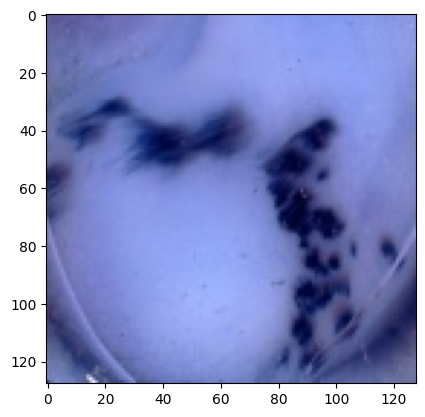

In [71]:
# sanity check
image_x = random.randint(0, len(segmented_images))
plt.imshow(segmented_images[image_x])
plt.show()


In [100]:
# Extract features
# Create an empty DataFrame
df_features_val = pd.DataFrame(
    columns=['image_id'])

lbp_features = []
hog_features = []
edge_features = []
gabor_features = []
mean_features = []
min_features = []
std_features = []
skewness_features = []
kurtosis_features = []


In [101]:
# Create an iterator with a progress bar
iterator = tqdm.tqdm(enumerate(segmented_images), total=len(segmented_images), desc="Extracting features from validation data")
skipped_images = 0
# Iterate over segmented images and extract features
for i, segmented_image in iterator:
    # Check if the segmented image is blank (all black pixels)
    if np.all(segmented_image == 0):
        skipped_images += 1
        continue

    # Extract features for the current image
    lbp_features.append(ext.extract_lbp_features(segmented_image))
    edge_features.append(ext.findehd(segmented_image))
    hog_features.append(ext.extract_hog_features(segmented_image))
    gabor_features.append(ext.extract_gabor_features(segmented_image, kernels))
    mean_feature, min_feature, std_feature, skewness_feature, kurtosis_feature = ext.extract_color_features(
        segmented_image)
    mean_features.append(mean_feature)
    min_features.append(min_feature)
    std_features.append(std_feature)
    skewness_features.append(skewness_feature)
    kurtosis_features.append(kurtosis_feature)

    # Get the corresponding image ID (file name)
    image_id = os.path.splitext(segmented_image_files[i])[0]

    # Create a row for the DataFrame with the features and image ID
    row = pd.DataFrame({
        'image_id': [image_id]
    })

    # Append the row DataFrame to the main DataFrame
    df_features_val = pd.concat([df_features_val, row], ignore_index=True)


Extracting features from validation data: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


In [102]:
print(f"Number of skipped blank images from validation data: {skipped_images}")

Number of skipped blank images from validation data: 0


In [103]:
df_lbp_features = pd.DataFrame(np.array(lbp_features))
column_labels = [f"lpb_{i + 1}" for i in range(df_lbp_features.shape[1])]
df_lbp_features.columns = column_labels

df_edge_features = pd.DataFrame(np.array(edge_features))
column_labels = [f"edge_{i + 1}" for i in range(df_edge_features.shape[1])]
df_edge_features.columns = column_labels

df_hog_features = pd.DataFrame(np.array(hog_features))
column_labels = [f"hog_{i + 1}" for i in range(df_hog_features.shape[1])]
df_hog_features.columns = column_labels

for i, kernel in enumerate(kernels):
    column_labels = [f'k{i + 1}_mean', f'k{i + 1}_var']
    feats = np.array(gabor_features)[:, i, :]
    df_gabor_features = pd.DataFrame(feats, columns=column_labels)
    df_features_val = pd.concat([df_features_val, df_gabor_features], axis=1)

df_mean_features = pd.DataFrame(np.array(mean_features))
column_labels = ['r_mean', 'g_mean', 'b_mean', 'l_mean', 'u_mean', 'v_mean']
df_mean_features.columns = column_labels

df_min_features = pd.DataFrame(np.array(min_features))
column_labels = ['r_min', 'g_min', 'b_min', 'l_min', 'u_min', 'v_min']
df_min_features.columns = column_labels

df_std_features = pd.DataFrame(np.array(std_features))
column_labels = ['r_std', 'g_std', 'b_std', 'l_std', 'u_std', 'v_std']
df_std_features.columns = column_labels

df_skewness_features = pd.DataFrame(np.array(skewness_features))
column_labels = ['r_skew', 'g_skew', 'b_skew', 'l_skew', 'u_skew', 'v_skew']
df_skewness_features.columns = column_labels

df_kurtosis_features = pd.DataFrame(np.array(kurtosis_features))
column_labels = ['r_kurt', 'g_kurt', 'b_kurt', 'l_kurt', 'u_kurt', 'v_kurt']
df_kurtosis_features.columns = column_labels

df_features_val = pd.concat(
    [df_features_val, df_lbp_features, df_hog_features, df_edge_features, df_mean_features, df_min_features,
     df_std_features, df_skewness_features, df_kurtosis_features], axis=1)


In [110]:
df_features_val

,image_id,k1_mean,k1_var,k2_mean,k2_var,k3_mean,k3_var,k4_mean,k4_var,k5_mean,...,l_skew,u_skew,v_skew,r_kurt,g_kurt,b_kurt,l_kurt,u_kurt,v_kurt,class
0,ISIC_0,136.766113,149.260360,41.461853,15.207773,92.095581,60.789082,0.884949,221.483650,136.768250,...,-2.569194,3.398034,2.857902,4.138339,6.467677,12.250507,9.410343,10.119021,7.484356,2
1,ISIC_1,127.248779,161.971190,38.546692,16.622454,85.674194,64.279471,1.066711,268.750249,127.249390,...,-3.178749,-2.395177,0.100351,3.142048,11.707215,8.798235,20.767852,4.067166,2.644779,2
2,ISIC_10,133.937561,180.994209,40.597656,19.411728,90.191589,77.302832,6.291260,1547.664191,133.937805,...,-2.307191,-1.709324,1.613100,0.984231,14.658242,0.985889,12.311486,1.123818,0.890010,2
3,ISIC_100,106.442871,123.620760,32.490417,69.723419,71.638611,48.162428,3.442200,852.995560,106.443542,...,-4.415226,-1.395196,-1.609557,12.006543,23.894998,42.670430,28.515325,2.923531,2.981911,2
4,ISIC_101,130.384216,308.026633,39.577576,46.461633,87.787170,119.586723,14.924316,3545.964975,130.386536,...,-1.694701,-0.278146,-0.273656,1.003198,3.676215,40.213509,5.644897,-0.980380,-1.454769,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_95,113.489014,36.165651,34.346191,5.070825,76.392517,12.675825,3.010132,748.299336,113.490417,...,-3.297447,0.904524,0.057155,8.012008,23.893977,102.840999,31.137972,1.203015,3.134727,1
146,ISIC_96,132.539185,209.129324,40.169556,21.769713,89.242676,87.294014,2.401428,601.203907,132.539917,...,-1.990749,-0.471905,-0.903106,3.967960,4.670544,16.732005,5.727336,1.139545,0.439204,1
147,ISIC_97,130.121887,167.512060,39.428894,18.725046,87.614563,66.032285,4.768616,1181.054066,130.120178,...,-2.981933,0.488490,0.130845,7.322186,11.292971,26.226746,13.114619,1.979465,0.981510,1
148,ISIC_98,185.532715,64.933622,56.369385,7.893340,124.992432,21.995914,1.255249,314.374911,185.536011,...,-7.139651,0.276576,0.106804,48.807618,66.954655,107.508700,78.632685,0.913655,4.552788,2


In [105]:
# Load the class CSV file with classes
# Define the folder path where the class CSV file is located
class_folder_val = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/segmented_images/val"

# Load the class CSV file
class_csv_file = [file for file in os.listdir(class_folder_val) if file.endswith(".csv")]

class_csv_path = os.path.join(class_folder_val, class_csv_file[0])
df_classes_val = pd.read_csv(class_csv_path, usecols=["image_id", "class"])


In [106]:
df_classes_val

,image_id,class
0,ISIC_0,2
1,ISIC_1,2
2,ISIC_2,2
3,ISIC_3,2
4,ISIC_4,2
...,...,...
145,ISIC_145,2
146,ISIC_146,2
147,ISIC_147,2
148,ISIC_148,2


In [107]:
# Merge df_features with df_classes based on image_id
df_features_val = pd.merge(df_features_val, df_classes_val, on="image_id", how="inner")

In [109]:
# Drop rows with missing or null class information
df_features_val = df_features_val.dropna(subset=["class"])

# Export DataFrame as csv file
# Define the file path and name
save_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/SVM"
csv_file_path = os.path.join(save_directory, "features_val.csv")

In [141]:
# Export DataFrames as csv files
# Define the file path and name
save_directory = "C:/Users/Patrick/Desktop/Capstone/Patrick's Codes - Phase 1/data/extracted_features"
train_file_path = os.path.join(save_directory, "df_features_train.csv")
test_file_path = os.path.join(save_directory, "df_features_test.csv")
val_file_path = os.path.join(save_directory, "df_features_val.csv")

# Export DataFrame to Excel
pd.DataFrame(df_features_train).to_csv(train_file_path, index=False)
pd.DataFrame(df_features_test).to_csv(test_file_path, index=False)
pd.DataFrame(df_features_val).to_csv(val_file_path, index=False)
print('Features Extracted!')


Features Extracted!


Credits to: Simone Marawa